# Finetune A Pretrained BERT Model On YELP

There are significant benefits to using a pretrained model. It reduces
computation costs, your carbon footprint, and allows you to use state-of-the-art
models without having to train one from scratch. 🤗 Transformers provides access
to thousands of pretrained models for a wide range of tasks. When you use a
pretrained model, you train it on a dataset specific to your task. This is known
as fine-tuning, an incredibly powerful training technique. In this tutorial, you
will fine-tune a pretrained model with a deep learning framework of your choice.

### IMDB Dataset

[Wakaka/bert-finetuned-imdb](https://huggingface.co/Wakaka/bert-finetuned-imdb)

[Damon-Salvatore-liu/bert_imdb](https://github.com/Damon-Salvatore-liu/bert_imdb/blob/main/test.ipynb)

- [x] M1
- [x] Colab
- [ ] [pig4431/YELP_BERT_5E](https://huggingface.co/pig4431/YELP_BERT_5E)
- [ ] [jenniferjane/Bert_Classifier](https://huggingface.co/jenniferjane/Bert_Classifier/tree/main)

In [1]:
SEED=42

DATASET="yelp_review_full"

MODEL="bert-base-cased"

SMALL_DATASET_SIZE=1000
LARGE_DATASET_SIZE=10000

EPOCHS=5

## Get Raw Datasets

In [2]:
from datasets import load_dataset

datasets = load_dataset(DATASET)

Found cached dataset yelp_review_full (/Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf)


  0%|          | 0/2 [00:00<?, ?it/s]

In [3]:
datasets

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 650000
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 50000
    })
})

In [4]:
datasets["train"][100]

{'label': 0,
 'text': 'My expectations for McDonalds are t rarely high. But for one to still fail so spectacularly...that takes something special!\\nThe cashier took my friends\'s order, then promptly ignored me. I had to force myself in front of a cashier who opened his register to wait on the person BEHIND me. I waited over five minutes for a gigantic order that included precisely one kid\'s meal. After watching two people who ordered after me be handed their food, I asked where mine was. The manager started yelling at the cashiers for \\"serving off their orders\\" when they didn\'t have their food. But neither cashier was anywhere near those controls, and the manager was the one serving food to customers and clearing the boards.\\nThe manager was rude when giving me my order. She didn\'t make sure that I had everything ON MY RECEIPT, and never even had the decency to apologize that I felt I was getting poor service.\\nI\'ve eaten at various McDonalds restaurants for over 30 years. 

This sample selection could have been proudly sponsored by

![Burger_King](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cc/Burger_King_2020.svg/220px-Burger_King_2020.svg.png)

### Prepare/Tokenize Train/Eval Dataset

In [5]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

tokenized_datasets = datasets.map(tokenize_function, batched=True)

Loading cached processed dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-a672216cdfb09c9b.arrow
Loading cached processed dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-ae71c631b0b6a605.arrow


In [6]:
small_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(SMALL_DATASET_SIZE))
small_eval_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(SMALL_DATASET_SIZE))

large_train_dataset = tokenized_datasets["train"].shuffle(seed=SEED).select(range(LARGE_DATASET_SIZE))
large_eval_dataset = tokenized_datasets["test"].shuffle(seed=SEED).select(range(LARGE_DATASET_SIZE))

full_train_dataset = tokenized_datasets["train"]
full_eval_dataset = tokenized_datasets["test"]

Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-9edbabb881154e45.arrow
Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-51e4392d834261d1.arrow
Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-9edbabb881154e45.arrow
Loading cached shuffled indices for dataset at /Users/lothar/.cache/huggingface/datasets/yelp_review_full/yelp_review_full/1.0.0/e8e18e19d7be9e75642fc66b198abadb116f73599ec89a69ba5dd8d1e57ba0bf/cache-51e4392d834261d1.arrow


<a id='trainer'></a>

## Train with PyTorch Trainer

In [7]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL,
    num_labels=5
)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

The warning about some of the pretrained weights not being used and being
randomly initialized is expected.

The pretrained head of the BERT model is discarded, and replaced with a randomly
initialized new classification head of the BERT model.

This new model head is fine-tuned on the new sequence classification task,
transferring the knowledge of the former pretrained model to the new finetuned
model.

### Evaluate

In [8]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

### TrainingArguments

In [9]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="epoch",
    logging_strategy="no",
    save_strategy="no",
    num_train_epochs=EPOCHS,
    use_mps_device=True
)

### Trainer

In [10]:
from transformers import Trainer

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=small_train_dataset,
    eval_dataset=small_eval_dataset,
#    train_dataset=large_train_dataset,
#    eval_dataset=large_eval_dataset,
#    train_dataset=full_train_dataset,
#    eval_dataset=full_eval_dataset,
    compute_metrics=compute_metrics
)

### Finetune/Train The Model

In [11]:
trainer.train()

/opt/homebrew/Caskroom/miniforge/base/envs/pytorch_huggingface_m1/lib/python3.10/site-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.3207215070724487, 'eval_accuracy': 0.396, 'eval_runtime': 26.2264, 'eval_samples_per_second': 38.13, 'eval_steps_per_second': 4.766, 'epoch': 1.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.1246384382247925, 'eval_accuracy': 0.512, 'eval_runtime': 25.742, 'eval_samples_per_second': 38.847, 'eval_steps_per_second': 4.856, 'epoch': 2.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.1048789024353027, 'eval_accuracy': 0.548, 'eval_runtime': 27.1527, 'eval_samples_per_second': 36.829, 'eval_steps_per_second': 4.604, 'epoch': 3.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.2423869371414185, 'eval_accuracy': 0.594, 'eval_runtime': 27.1157, 'eval_samples_per_second': 36.879, 'eval_steps_per_second': 4.61, 'epoch': 4.0}


  0%|          | 0/125 [00:00<?, ?it/s]

{'eval_loss': 1.3701896667480469, 'eval_accuracy': 0.574, 'eval_runtime': 27.2238, 'eval_samples_per_second': 36.733, 'eval_steps_per_second': 4.592, 'epoch': 5.0}
{'train_runtime': 632.1265, 'train_samples_per_second': 7.91, 'train_steps_per_second': 0.989, 'train_loss': 0.845147265625, 'epoch': 5.0}


TrainOutput(global_step=625, training_loss=0.845147265625, metrics={'train_runtime': 632.1265, 'train_samples_per_second': 7.91, 'train_steps_per_second': 0.989, 'train_loss': 0.845147265625, 'epoch': 5.0})

In [12]:
step_list = [log['step'] for log in trainer.state.log_history[:-1]]

eval_loss_list = [log['eval_loss'] for log in trainer.state.log_history[:-1]]

eval_accuracy_list = [log['eval_accuracy'] for log in trainer.state.log_history[:-1]]

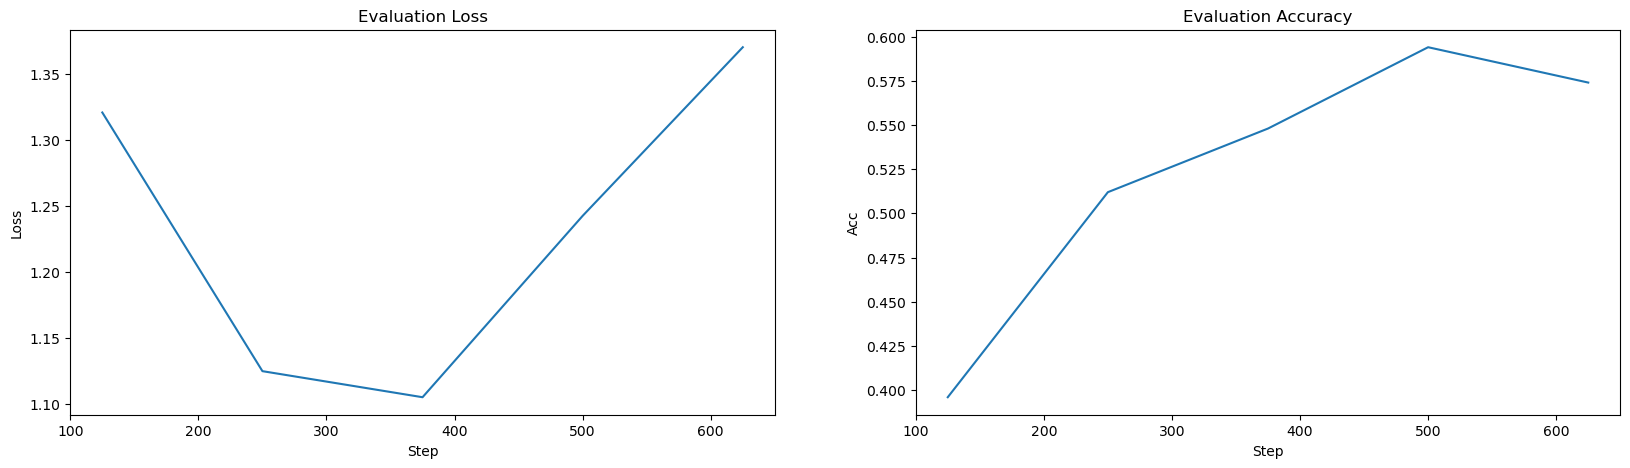

In [13]:
import matplotlib.pyplot as plt

plt.subplots(1,2, figsize=(20,5))

plt.subplot(1, 2, 1)
plt.title("Evaluation Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.plot(step_list, eval_loss_list)

plt.subplot(1, 2, 2)
plt.title("Evaluation Accuracy")
plt.xlabel("Step")
plt.ylabel("Acc")
plt.plot(step_list, eval_accuracy_list)

plt.show()

Adapted from [🤗 Transformers Notebook 'Finetune A Pretrained Model'](https://github.com/huggingface/notebooks/blob/main/transformers_doc/en/training.ipynb).